# Prepare data

In [6]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
import spacy

from hpsklearn import HyperoptEstimator

General notes
- Glove good
- hyperopt sus


In [99]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')

In [142]:
# glove twitter

nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])
print(X.shape)

#maybe try gensim? or stick with glove idk

(2402, 200)


In [141]:
pheme['e_text']

0      -0.276887
1      -0.141769
2      -0.332791
3      -0.334760
4      -0.340875
          ...   
2397    0.009545
2398   -0.166456
2399    0.072416
2400   -0.101971
2401    0.261765
Name: e_text, Length: 2402, dtype: float32

In [83]:
X_new = np.column_stack((X, pheme['event']))
X_new.shape

(2402, 201)

In [143]:
pheme['e_text'] = X.tolist()
pheme

,Unnamed: 0,text,date,fav_count,retweet_count,username,account_date,followers,followings,tweet_count,protected,verified,no_hashtags,urls,event,target,e_text
0,0,break least dead injur gunman open fire offic ...,Wed Jan 07 11:06:08 +0000 2015,14,159,H_E_Samuel,Tue Oct 04 09:36:17 +0000 2011,1628,246,1901,False,False,0,[],charliehebdo-all-rnr-threads,True,"[-0.2768873870372772, 0.07383663952350616, -0...."
1,1,franc peopl dead shoot hq satir weekli newspap...,Wed Jan 07 11:07:51 +0000 2015,38,486,euronews,Wed Mar 18 12:57:11 +0000 2009,129573,337,48440,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.14176881313323975, -0.011955440044403076, ..."
2,2,ten kill shoot headquart french satir weekli c...,Wed Jan 07 11:08:09 +0000 2015,15,127,Channel4News,Mon Apr 28 14:29:37 +0000 2008,529882,3051,66682,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.33279091119766235, -0.03940924257040024, -..."
3,3,break dead shoot headquart french satir weekli...,Wed Jan 07 11:09:50 +0000 2015,15,105,AlArabiya_Eng,Sat Feb 28 08:31:32 +0000 2009,499741,31,100466,False,True,2,[],charliehebdo-all-rnr-threads,True,"[-0.3347603678703308, -0.05270244926214218, 0...."
4,4,reuter peopl shot dead headquart french satir ...,Wed Jan 07 11:11:16 +0000 2015,32,412,SkyNewsBreak,Wed Nov 04 11:25:45 +0000 2009,1377384,6,27228,False,True,1,[],charliehebdo-all-rnr-threads,True,"[-0.3408753275871277, 0.021153461188077927, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,2397,polic confirm sydneysieg final two peopl repor...,Mon Dec 15 15:52:04 +0000 2014,133,110,Angus_OL,Wed Dec 30 23:59:26 +0000 2009,90208,623,34310,False,True,1,[],sydneysiege-all-rnr-threads,True,"[0.00954464077949524, 0.03523699939250946, -0...."
2398,2398,sad end peopl dead seriou condit hostag sieg s...,Mon Dec 15 15:53:35 +0000 2014,38,252,HalaGorani,Thu Mar 19 16:41:46 +0000 2009,143771,626,10364,False,True,1,[],sydneysiege-all-rnr-threads,True,"[-0.166455939412117, 0.038812316954135895, 0.0..."
2399,2399,seven peopl reportedli taken away stretcher pa...,Mon Dec 15 15:54:41 +0000 2014,46,167,SkyNews,Thu Jul 19 14:42:53 +0000 2007,1731616,17,120340,False,True,1,"[{'url': 'http://t.co/mZ1o7Bi9kC', 'indices': ...",sydneysiege-all-rnr-threads,True,"[0.07241649925708771, -0.18050141632556915, -0..."
2400,2400,break cnn sydney polic storm cafe confirm dead...,Mon Dec 15 15:55:31 +0000 2014,26,117,AnneBayefsky,Tue Jul 26 19:02:54 +0000 2011,104665,52542,8066,False,False,0,"[{'url': 'http://t.co/FBnfHqKkeP', 'indices': ...",sydneysiege-all-rnr-threads,True,"[-0.10197066515684128, 0.18192364275455475, -0..."


In [127]:
pheme_train = pheme.drop('target', axis=1)
X_tr, X_te, y_train, y_test = train_test_split(pheme_train, pheme['target'], test_size = 0.25, random_state = 42)
X_train = np.array([text for text in X_tr['e_text']])
X_test = np.array([text for text in X_te['e_text']])

In [29]:
nlp = spacy.load("spacy-twitter")


def embed_two_datasets(set1, set2):
    nlp = spacy.load("spacy-twitter")
    all_statements = np.append(set1, set2)
    all_tf = np.array([nlp(text).vector for text in all_statements])
    return all_tf[:len(set1)], all_tf[len(set1):]

X_train, X_test = embed_two_datasets(pheme['text'], twitter['text'])
y_train  = pheme['target']
y_test = twitter['verdict']

In [126]:
X_train[0]

array([-1.63431898e-01,  1.12950029e-02, -1.11088119e-02,  1.74455177e-02,
       -5.85208200e-02, -1.76803529e-01,  1.10093452e-01, -2.15273902e-01,
        2.78077632e-01, -4.49650884e-02,  4.08718139e-02, -4.60791215e-02,
       -5.32511413e-01,  7.07541853e-02,  1.83696017e-01,  1.33766189e-01,
        3.74601707e-02, -1.86841428e-01,  1.03463776e-01,  1.26906848e-02,
       -1.91559643e-01,  1.12894729e-01,  4.12340015e-02, -2.84296386e-02,
       -5.76055497e-02,  5.51376343e-01,  7.99404606e-02, -6.87500760e-02,
        2.06970915e-01,  1.04490727e-01,  8.68790075e-02,  5.06854504e-02,
        1.29711241e-01, -4.68790978e-02,  7.32579082e-02,  1.10942081e-01,
        4.73903641e-02,  5.22263646e-02,  7.28600100e-02, -1.02417819e-01,
        2.41153091e-01, -4.44584750e-02, -1.70413882e-01, -6.53838217e-02,
        1.41604515e-02,  2.83115394e-02, -4.98531833e-02, -5.45439981e-02,
        1.06133372e-01,  1.81733653e-01, -2.23652110e-01,  1.73849910e-01,
       -1.15079964e-02,  

In [ ]:
def encode_two_datasets(set1, set2):
    tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
    all_statements = np.append(set1, set2)
    all_tf = tfidf.fit_transform(all_statements)
    return all_tf[:len(set1)], all_tf[len(set1):]

In [ ]:
# DO NOT RUN THIS BLOCK UNLESS YOU WANT TO USE TFIDF ENCODING

rs = 42
method = 3
tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = CountVectorizer(max_df=0.6, min_df=0)

if method == 0:
    pheme_tf = tfidf.fit_transform(pheme['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(pheme_tf, pheme['target'], test_size = 0.25, random_state = rs)
elif method == 1:
    polit_tf = tfidf.fit_transform(politifact['statement'].values)
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    twitter_tf = tfidf.fit_transform(twitter['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_train, X_test = encode_two_datasets(twitter['text'].values, pheme['text'].values)
    y_test = pheme['target']
    y_train = twitter['verdict']
else:
    X_train, X_test = encode_two_datasets(politifact['statement'].values, pheme['text'].values)
    y_train = politifact['verdict']
    y_test = pheme['target']
    

# Set no. of folds
num_folds = 10

###Things to do: add more features
print(X_train.shape)

(1729, 6101)


# Run models

In [ ]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [ ]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [132]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=20,
                            trial_timeout=120)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [133]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True), X_train, y_train)

100%|██████████| 20/20 [00:02<00:00,  2.26s/trial, best loss: 0.19390581717451527]
{'learner': SVC(C=1.0371070874907629, coef0=0.06107185014738503, degree=5, kernel='poly',
    probability=True, random_state=1, shrinking=False,
    tol=0.0008222986148465243), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 79.37 %
F1: 78.77 %


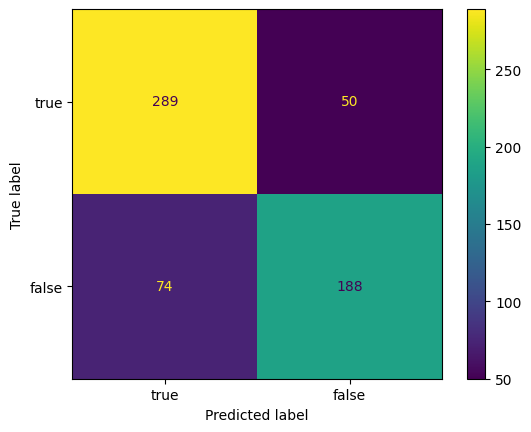

In [134]:
evaluate_model(svm, X_test, y_test)

In [33]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.63s/trial, best loss: 0.5301455301455301]
{'learner': KNeighborsClassifier(algorithm='brute', leaf_size=23, metric='cityblock',
                     n_jobs=1, n_neighbors=1, p=3.381536648387655), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 66.51 %
F1: 62.98 %


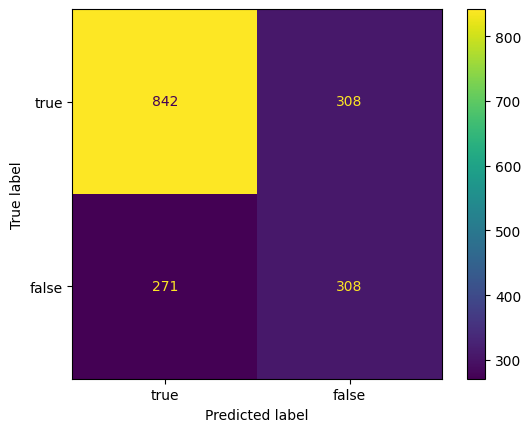

In [34]:
evaluate_model(knn, X_test, y_test)

In [37]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.47s/trial, best loss: 0.6798336798336798]
{'learner': LogisticRegression(C=1.9846757763617469, max_iter=465, n_jobs=1, random_state=3,
                   solver='liblinear', tol=0.0017463925633643923), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 63.33 %
F1: 59.73 %


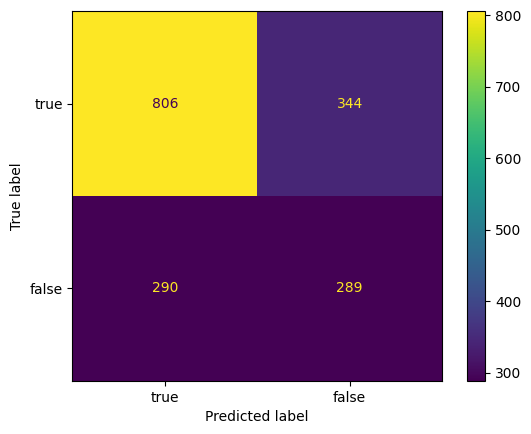

In [38]:
evaluate_model(myLR, X_test, y_test)

In [39]:
# AdaBoost
from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT), X_train, y_train)

100%|██████████| 50/50 [00:07<00:00,  7.58s/trial, best loss: 0.6216216216216216]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'learner': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=4,
                                                         max_features=0.007418448482818363,
                                                         random_state=3,
                                                         splitter='random'),
                   learning_rate=0.5950550641146849, n_estimators=244,
                   random_state=4), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 63.97 %
F1: 60.71 %


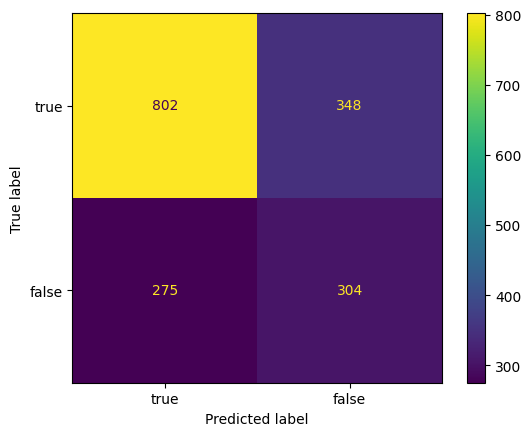

In [40]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [41]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp"), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:01<00:00,  1.64s/trial, best loss: 0.49064449064449067]
{'learner': MLPClassifier(alpha=0.004833034638813274, beta_1=0.803811552804277,
              beta_2=0.9632303881647765, epsilon=9.953130067042824e-06,
              learning_rate='adaptive', learning_rate_init=0.038399860294448265,
              max_fun=10435, max_iter=297, momentum=0.9333926705438431,
              power_t=0.17383863737828414, random_state=1,
              tol=0.002739448167495268,
              validation_fraction=0.023778141918354284), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 71.6 %
F1: 64.25 %


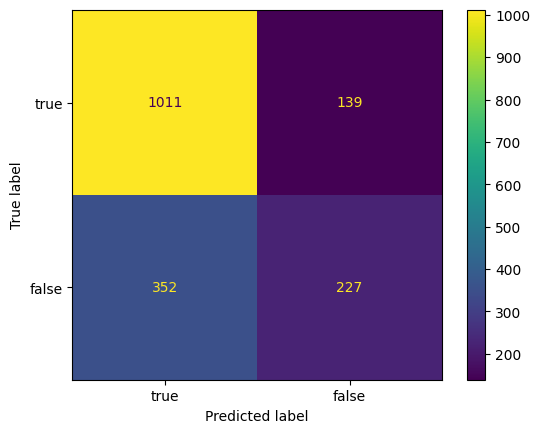

In [42]:
evaluate_model(mlp, X_test, y_test)

# Clustering

In [43]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture().fit(X_train)
gm.means_.shape



(1, 200)

## Ensemble

In [44]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 68.94 %
F1: 63.76 %


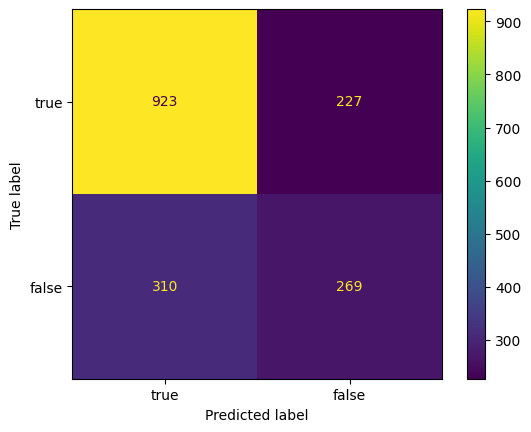

In [45]:
# Hard voting
from sklearn.ensemble import VotingClassifier

sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]
names = ["svm", "LR", "ada", "mlp", "knn"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 71.6 %
F1: 65.84 %


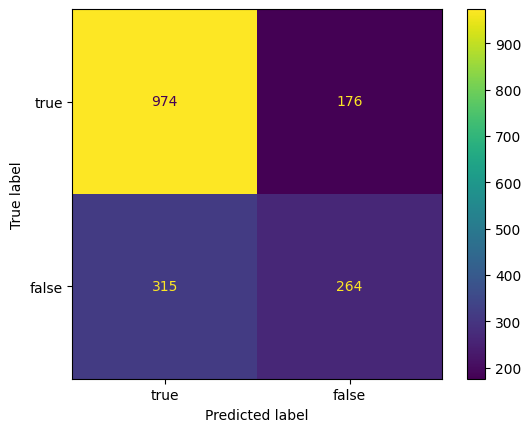

In [46]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

Accuracy: 69.52 %
F1: 64.28 %


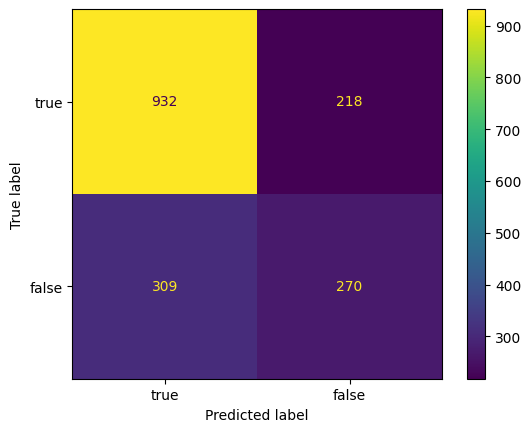

In [55]:
from deslib.des import KNORAE
sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]
names = ["svm", "LR", "ada", "mlp", "knn"]
e_ensemble = KNORAE(pool_classifiers=sk_classifiers)

e_ensemble.fit(X_train, y_train)
evaluate_model(e_ensemble, X_test, y_test)

Accuracy: 67.32 %
F1: 63.37 %


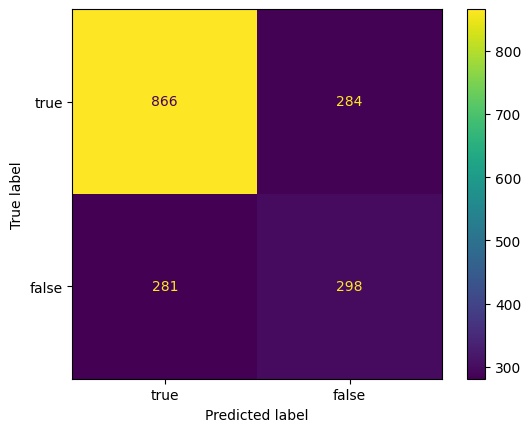

In [48]:
e_ensemble_soft = KNORAE(pool_classifiers=sk_classifiers, voting="soft")
e_ensemble_soft.fit(X_train, y_train)
evaluate_model(e_ensemble_soft, X_test, y_test)

Accuracy: 69.35 %
F1: 64.1 %


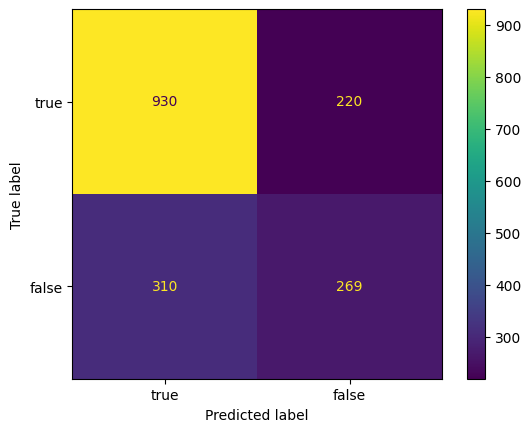

In [49]:
from deslib.des import KNORAU

u_ensemble_hard = KNORAU(pool_classifiers=sk_classifiers, knn_metric = "mahalanobis")

u_ensemble_hard.fit(X_train, y_train)
evaluate_model(u_ensemble_hard, X_test, y_test)

Accuracy: 71.08 %
F1: 65.7 %


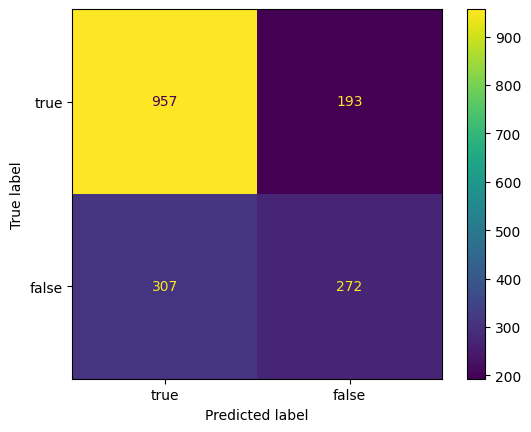

In [50]:
u_ensemble_soft = KNORAU(pool_classifiers=sk_classifiers, voting="soft")

u_ensemble_soft.fit(X_train, y_train)
evaluate_model(u_ensemble_soft, X_test, y_test)

# Custom model

In [230]:
def predict_points(points, ensemble):
    events = X_te['event'].values
    train_events = X_tr['event'].values
    trained_points = {}
    for i in range(len(train_events)):
        if train_events[i] in trained_points:
            trained_points[train_events[i]].append(i)
        else:
            trained_points[train_events[i]] = [i]
    
    final_predictions = []
    for j in range(len(points)):
        event = events[j]
        event_points = trained_points[event]
        model_predictions = []
        for model in ensemble:
            score = model.score(np.array([X_train[i] for i in event_points]), np.array([y_train.iloc[i] for i in event_points]))
            pred = model.predict(points[j].reshape(1,-1))
            model_predictions.append((score, pred[0]))
        #print(model_predictions)
        mark = 0
        for score, pred in model_predictions:    
            if pred == True:
                mark += score
            else:
                mark -= score
        #print(mark)
        if (mark > 0):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
    return final_predictions
                   
f = predict_points(X_test, [sk_svm, sk_knn, sk_LR, sk_ada, sk_mlp])


In [242]:
def check_score(a, b):
    num = 0
    den = 0
    for (x,y) in zip(a,b):
        if x == y:
            num += 1
            den += 1
        else:
            den += 1
    return num/den

check_score(f, y_test)


0.9367720465890182